## Exploring information from student grades in 902, 10th, and 11th grade.

In [1]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from pathlib import Path

# Custom utility functions
from utils.pipeline import remove_unregistered_students, retrieve_grade_reports
from utils.visualization import summary_subject_plot, summary_subject_table
warnings.filterwarnings('ignore')

# Machine Learning libraries
from sklearn.preprocessing import OrdinalEncoder, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression

# # MLflow for experiment tracking
# import mlflow
# import mlflow.sklearn
# from mlflow.models import infer_signature
# from mlflow.tracking import MlflowClient


## 1. Exploring data.

In [2]:
base = Path("./cleaned_data")
paths = sorted(base.glob("*.parquet"))

In [3]:
dfs = {p.stem : pd.read_parquet(p) for p in paths}

In [4]:
noveno_2 = {}
decimo_1 = {}
decimo_2 = {}
decimo_3 = {}
decimo_4 = {}
once_1 = {}
once_2 = {}
once_3 = {}


for name, df in dfs.items():
    if name.startswith("10_1"):
        decimo_1[name] = df
    elif name.startswith("10_2"):    
        decimo_2[name] = df
    elif name.startswith("10_3"):    
        decimo_3[name] = df
    elif name.startswith("10_4"):
        decimo_4[name] = df
    elif name.startswith("11_1"):
        once_1[name] = df
    elif name.startswith("11_2"):
        once_2[name] = df
    elif name.startswith("11_3"):
        once_3[name] = df
    elif name.startswith("9_2"):
        noveno_2[name] = df

#### 1.1 Cleaning dataset

In [5]:
noveno_2['9_2_1'].columns

Index(['Competencia', 'CONOCER', 'HACER', 'SER', 'CONVIVIR', 'Subtotal NIVEL',
       'Nota P1', 'Rec P1', 'Nota P2', 'Rec P2', 'Nota P3', 'Rec P3',
       'Nota PF', 'Rec PF', 'OBS  1', 'OBS  2', 'OBS  3', 'OBS  4', 'OBS  5',
       'LLEGADA TARDE', 'INASISTENCIA JUSTIFICADA',
       'INASISTENCIA INJUSTIFICADA', 'PERMISO', 'RETARDO'],
      dtype='object')

Columns to drop:

* `Competencia`
* `OBS n` where n = 1, 2, 3, 4, 5
* `Nota P3`,
* `Rec P3`,
* `Rec PF`

### 1.2 Analysing student cumulated grades in Chemistry.

In [6]:
to_analyse = {
    i: remove_unregistered_students(dfs[k])['Nota PF'].value_counts().reset_index()
    for i, k in enumerate(dfs)
    if i % 2 == 0    
}

In [7]:
order = ["S", "A", "B", "b"]
cat_cols = ['CONOCER', 'HACER', 'SER', 'CONVIVIR', 'Subtotal NIVEL', 'Nota P1', 'Nota P2', 'Nota P3', 'Nota PF']
dfs['10_1_1'][cat_cols] = dfs['10_1_1'][cat_cols].replace(
        {"None" : pd.NA, "": pd.NA}
    ).apply(
        lambda s: s.str.strip() if s.dtype =="object" else s
    ).apply(
        lambda s : pd.Categorical(s, categories=order, ordered=True)
    )

In [8]:
to_analyse[4].sort_values(by='Nota PF')

,Nota PF,count
1,S,9
0,A,24
2,B,6
3,b,1


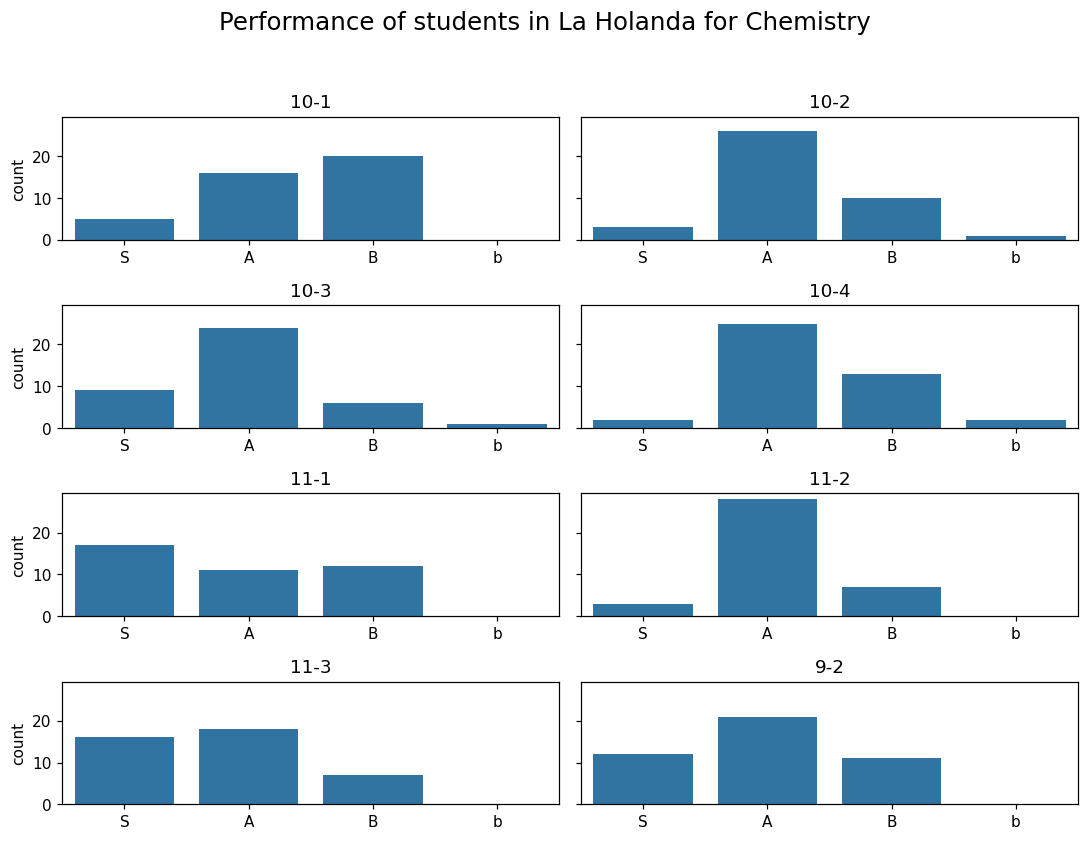

In [9]:
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(10, 8), dpi=110, sharex=False, sharey=True)

# Set a single title for the whole figure
fig.suptitle("Performance of students in La Holanda for Chemistry", fontsize=16)

# Plot the first 6 series from to_analyse into the 3x2 grid
for ax, series in zip(axes.flatten(), to_analyse.values()):
	sns.barplot(x=series['Nota PF'], y=series['count'], ax=ax)
	ax.set_xlabel("")
	ax.set_ylabel("count")
 
axes.flatten()[0].set_title("10-1")
axes.flatten()[1].set_title("10-2")
axes.flatten()[2].set_title("10-3")
axes.flatten()[3].set_title("10-4")
axes.flatten()[4].set_title("11-1")
axes.flatten()[5].set_title("11-2")
axes.flatten()[6].set_title("11-3")
axes.flatten()[7].set_title("9-2")

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


In [10]:
titles = ["10-1", "10-2", "10-3", "10-4", "11-1", "11-2", "11-3", "9-2"]
grades_analysis_for_all_courses = {
    key: grades.rename(
        columns={
            "Nota PF" : f"nota_pf_{key}",
            "count" : f"count_for_{key}"
            }
        ).sort_values(
            by=f"nota_pf_{key}",
            ascending=False
        )
    for key, grades in zip(titles, to_analyse.values())
}

In [11]:
concat_analysis = pd.concat(objs=grades_analysis_for_all_courses.values(), axis=1, ignore_index=True)

In [12]:
concat_analysis.drop(columns=np.arange(2, 15, 2), inplace=True)

In [13]:
concat_analysis = concat_analysis.rename(
    columns={
        0:"nota_pf",
        1:"10_1",
        3:"10_2",
        5:"10_3",
        7:"10_4",
        9:"11_1",
        11:"11_2",
        13:"11_3",
        15:"9_2"
    }
)

concat_analysis.sort_values(by='nota_pf', ascending=False, inplace=True)

In [14]:
proportion_concat = concat_analysis.copy()

# Proportion for 10th levels.
proportion_concat['10'] = proportion_concat[['nota_pf', '10_1', '10_2', '10_3', '10_4']].sum(axis=1, numeric_only=True)
proportion_concat['10'] *= (1/proportion_concat['10'].sum()) * 100
proportion_concat.drop(columns=['9_2','10_1', '10_2', '10_3', '10_4'], inplace=True)

# Proportion for 11th levels.
proportion_concat['11'] =proportion_concat[['nota_pf', '11_1', '11_2', '11_3']].sum(axis=1, numeric_only=True)
proportion_concat['11'] *= (1/proportion_concat['11'].sum()) * 100
proportion_concat.drop(columns=['11_1', '11_2', '11_3'], inplace=True)

In [15]:
melted_concat_analysis = concat_analysis.melt(
    id_vars='nota_pf',
    var_name='group'
)

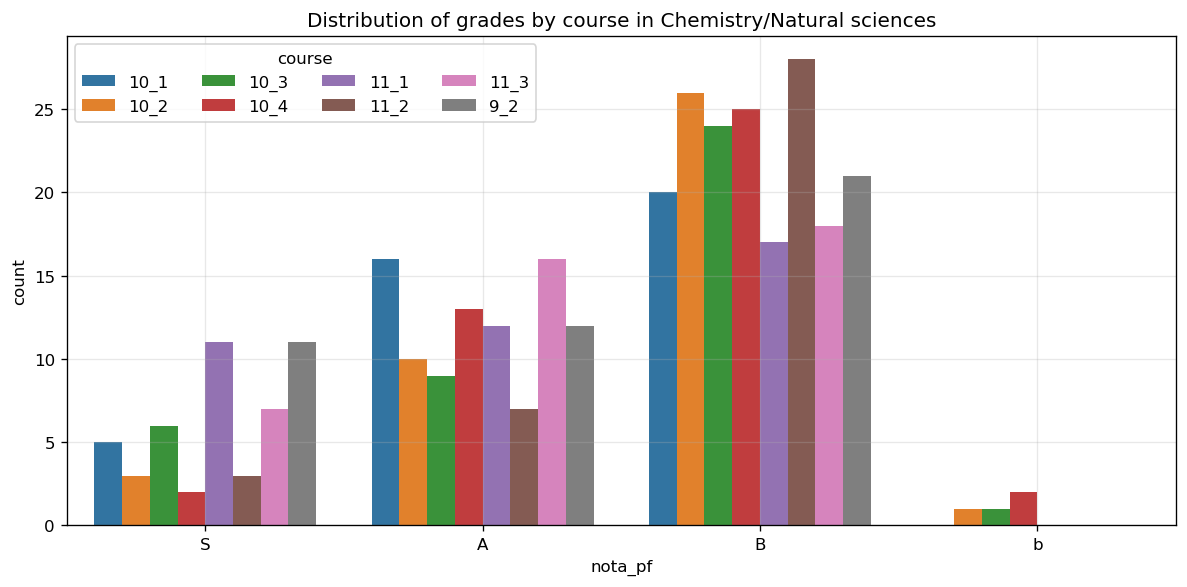

In [16]:
plt.figure(figsize=(10,5), dpi=120)
sns.barplot(data=melted_concat_analysis, x='nota_pf', y='value', hue='group', order=order)
plt.title('Distribution of grades by course in Chemistry/Natural sciences')
plt.xlabel('nota_pf')
plt.ylabel('count')
plt.legend(title='course', ncol=4)   # tidy legend
plt.tight_layout()
plt.grid(alpha=2/7)
plt.show()

In [17]:
proportion_concat

,nota_pf,10,11
3,b,2.453988,0.000000
0,B,58.282209,52.941176
1,A,29.447853,29.411765
2,S,9.815951,17.647059


In [18]:
proportion_concat.melt(id_vars='nota_pf', var_name='group')

,nota_pf,group,value
0,b,10,2.453988
1,B,10,58.282209
2,A,10,29.447853
3,S,10,9.815951
4,b,11,0.000000
5,B,11,52.941176
6,A,11,29.411765
7,S,11,17.647059


INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


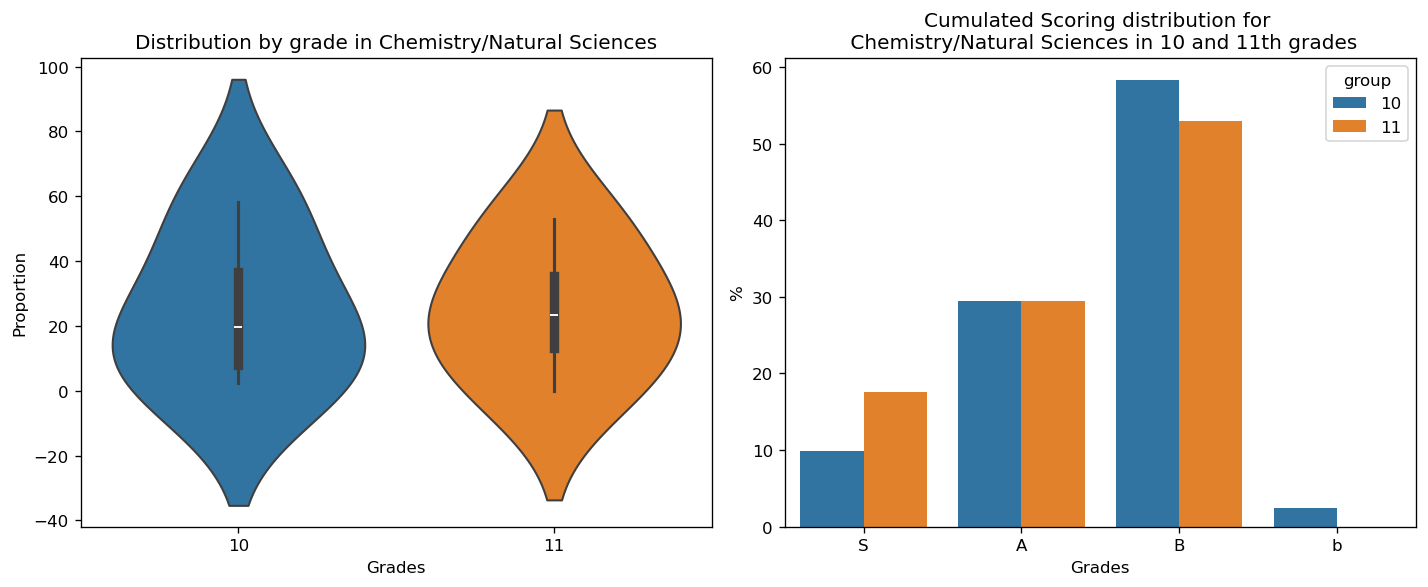

In [19]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 5), dpi=120)
sns.violinplot(
    data=proportion_concat,
    ax=ax1
    # order=order
)
sns.barplot(
    data=proportion_concat.melt(id_vars='nota_pf', var_name='group'),
    x='nota_pf',
    y='value',
    hue='group',
    ax=ax2,
)

ax1.set_title('Distribution by grade in Chemistry/Natural Sciences')
ax1.set_xlabel('Grades')
ax1.set_ylabel('Proportion')

ax2.set_title('Cumulated Scoring distribution for \n Chemistry/Natural Sciences in 10 and 11th grades')
ax2.set_xlabel('Grades')
ax2.set_ylabel('%')

plt.tight_layout()
plt.show()

### 1.3 Cleaning data from cumulated grades in math and spanish.

In [20]:
path_for_9_2 = './consolidados/consolidado_902.xls'
path_for_10_1 = './consolidados/consolidado_1001.xls'
path_for_10_2 = './consolidados/consolidado_1002.xls'
path_for_10_3 = './consolidados/consolidado_1003.xls'
path_for_10_4 = './consolidados/consolidado_1004.xls'
path_for_11_1 = './consolidados/consolidado_1101.xls'
path_for_11_2 = './consolidados/consolidado_1102.xls'
path_for_11_3 = './consolidados/consolidado_1103.xls'

*1.3.1: Reading individual files for 9*

In [21]:
p1_9_2 = retrieve_grade_reports(path_for_9_2, final_student=95)["p1"]
p2_9_2 = retrieve_grade_reports(path_for_9_2, final_student=95)["p2"]

*1.3.2: Reading individual files for 10*

*1.3.2.1 : 10.1*

In [22]:
p1_10_1 = retrieve_grade_reports(path_for_10_1, final_student=82)["p1"]
p2_10_1 = retrieve_grade_reports(path_for_10_1, final_student=82)["p2"]

*1.3.2.2 : 10.2*

In [23]:
p1_10_2 = retrieve_grade_reports(path_for_10_2, final_student=81)["p1"]
p2_10_2 = retrieve_grade_reports(path_for_10_2, final_student=81)["p2"]

*1.3.2.3: 10.3*

In [24]:
p1_10_3 = retrieve_grade_reports(path_for_10_3, final_student=85)["p1"]
p2_10_3 = retrieve_grade_reports(path_for_10_3, final_student=85)["p2"]

*1.3.2.3: 10.4*

In [25]:
p1_10_4 = retrieve_grade_reports(path_for_10_4, final_student=84)["p1"]
p2_10_4 = retrieve_grade_reports(path_for_10_4, final_student=84)["p2"]

*1.3.3: Reading individual files for 11*

*1.3.3.1 : 11.1*

In [26]:
p1_11_1 = retrieve_grade_reports(path_for_11_1, final_student=82)["p1"]
p2_11_1 = retrieve_grade_reports(path_for_11_1, final_student=82)["p2"]

*1.3.3.2 : 11.2*

In [27]:
p1_11_2 = retrieve_grade_reports(path_for_11_2, final_student=80)["p1"]
p2_11_2 = retrieve_grade_reports(path_for_11_2, final_student=80)["p2"]

*1.3.3.3 : 11.3*

In [28]:
p1_11_3 = retrieve_grade_reports(path_for_11_3, final_student=82)["p1"]
p2_11_3 = retrieve_grade_reports(path_for_11_3, final_student=82)["p2"]

### 1.4 Analysing student cumulated grades in math and spanish

#### 1.4.1 Period 1

In [29]:
# Math and spanish cols
cols_9 = ['nota', 'esp', 'mat']
cols_growns = ['nota', 'esp', 'lect', 'mat']

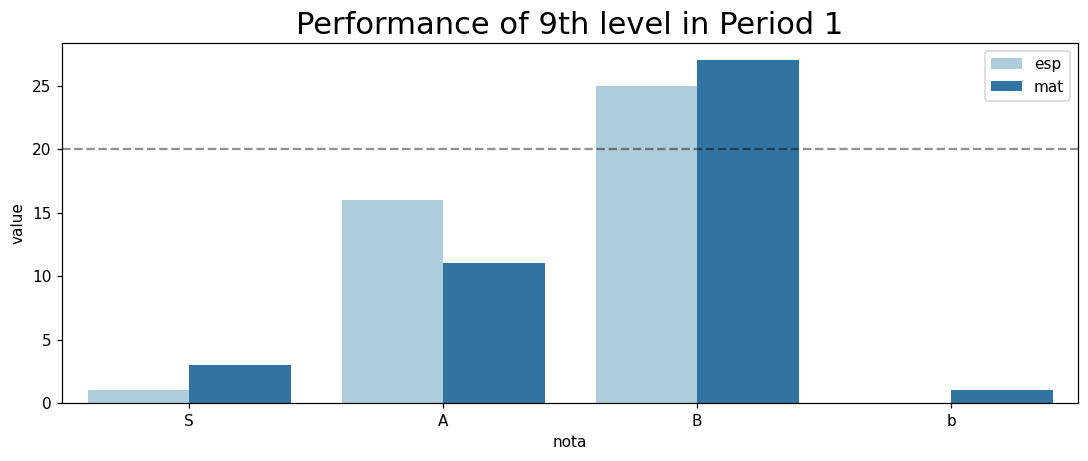

In [30]:
summary_subject_plot(p1_9_2, size=(10, 4), cols=cols_9, palette='Paired')
plt.axhline(y=20, xmin=0, xmax=1, linestyle="--", linewidth=1.5, zorder=10, alpha=3/7, color='black')
plt.title("Performance of 9th level in Period 1", fontsize=20)
plt.show()

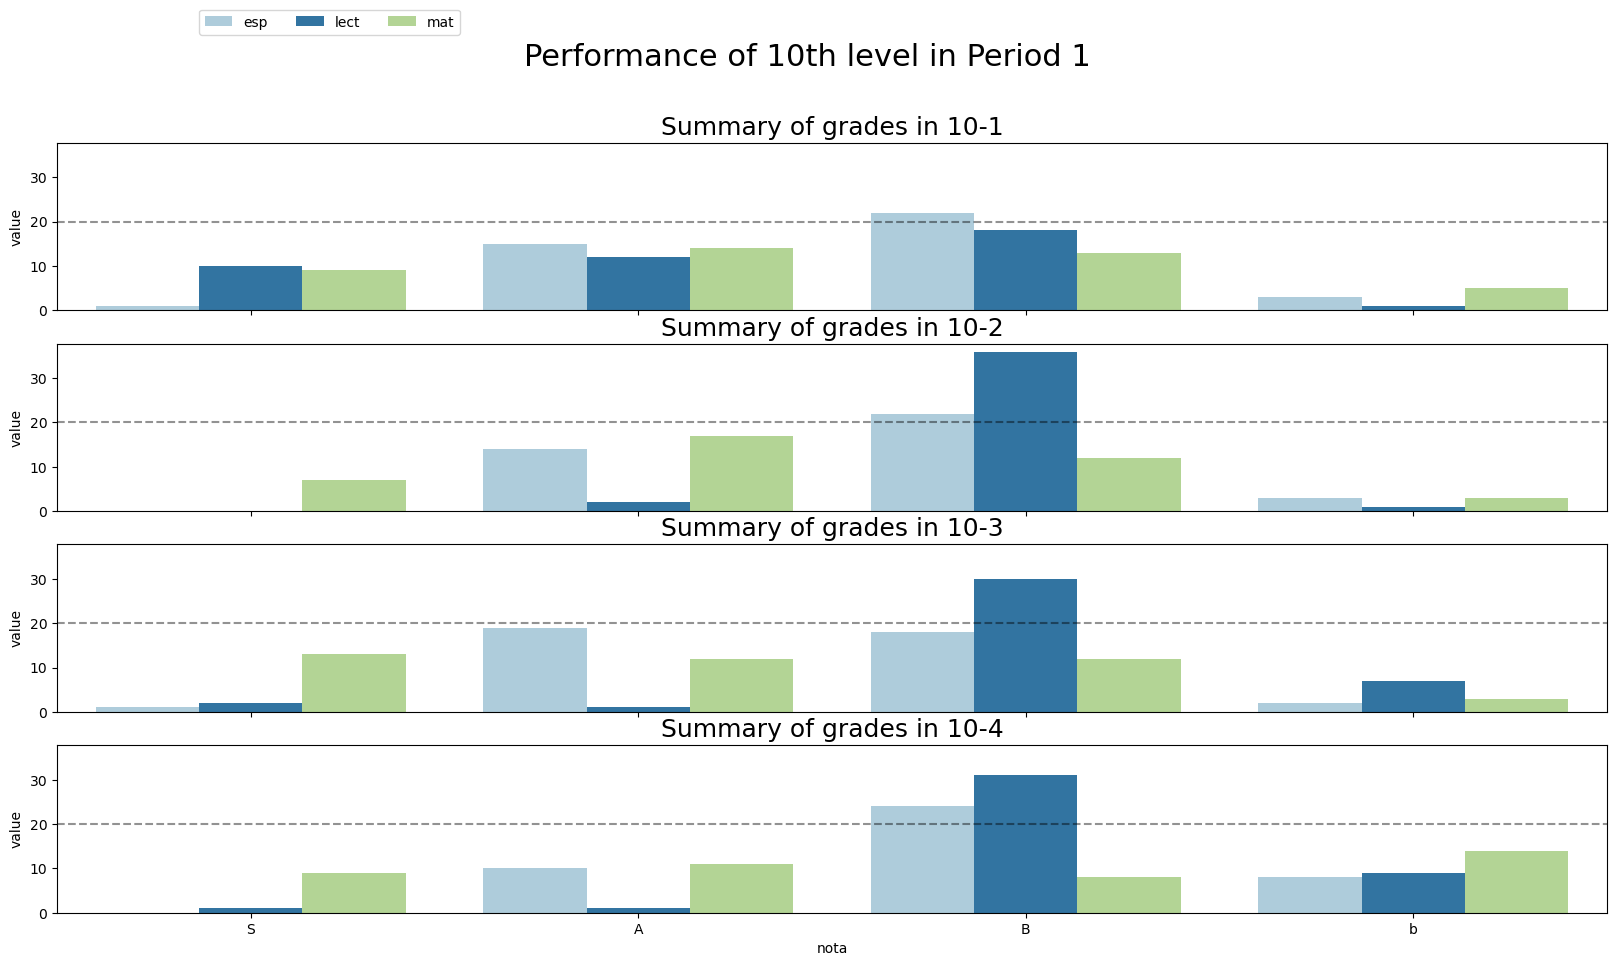

In [31]:
fig, axes = plt.subplots(4, 1, figsize=(20, 10), sharex=True, sharey=True)
titles = ["10-1", "10-2", "10-3", "10-4"]
for ax, grades, title in zip(axes, [p1_10_1, p1_10_2, p1_10_3, p1_10_4], titles):
    summary_subject_plot(grades, palette='Paired', ax=ax, show_legend=False, size=(14, 14), cols=cols_growns)
    ax.set_title(f"Summary of grades in {title}", fontdict={"fontsize": 18})
    ax.axhline(y=20, xmin=0, xmax=1, linestyle="--", linewidth=1.5, zorder=10, alpha=3/7, color='black')

handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc="upper right", ncol=4, bbox_to_anchor=(0.33, 1.02))

fig.tight_layout(rect=[0, 1, 1, 0.92])
plt.suptitle("Performance of 10th level in Period 1", fontsize=22)
plt.show()

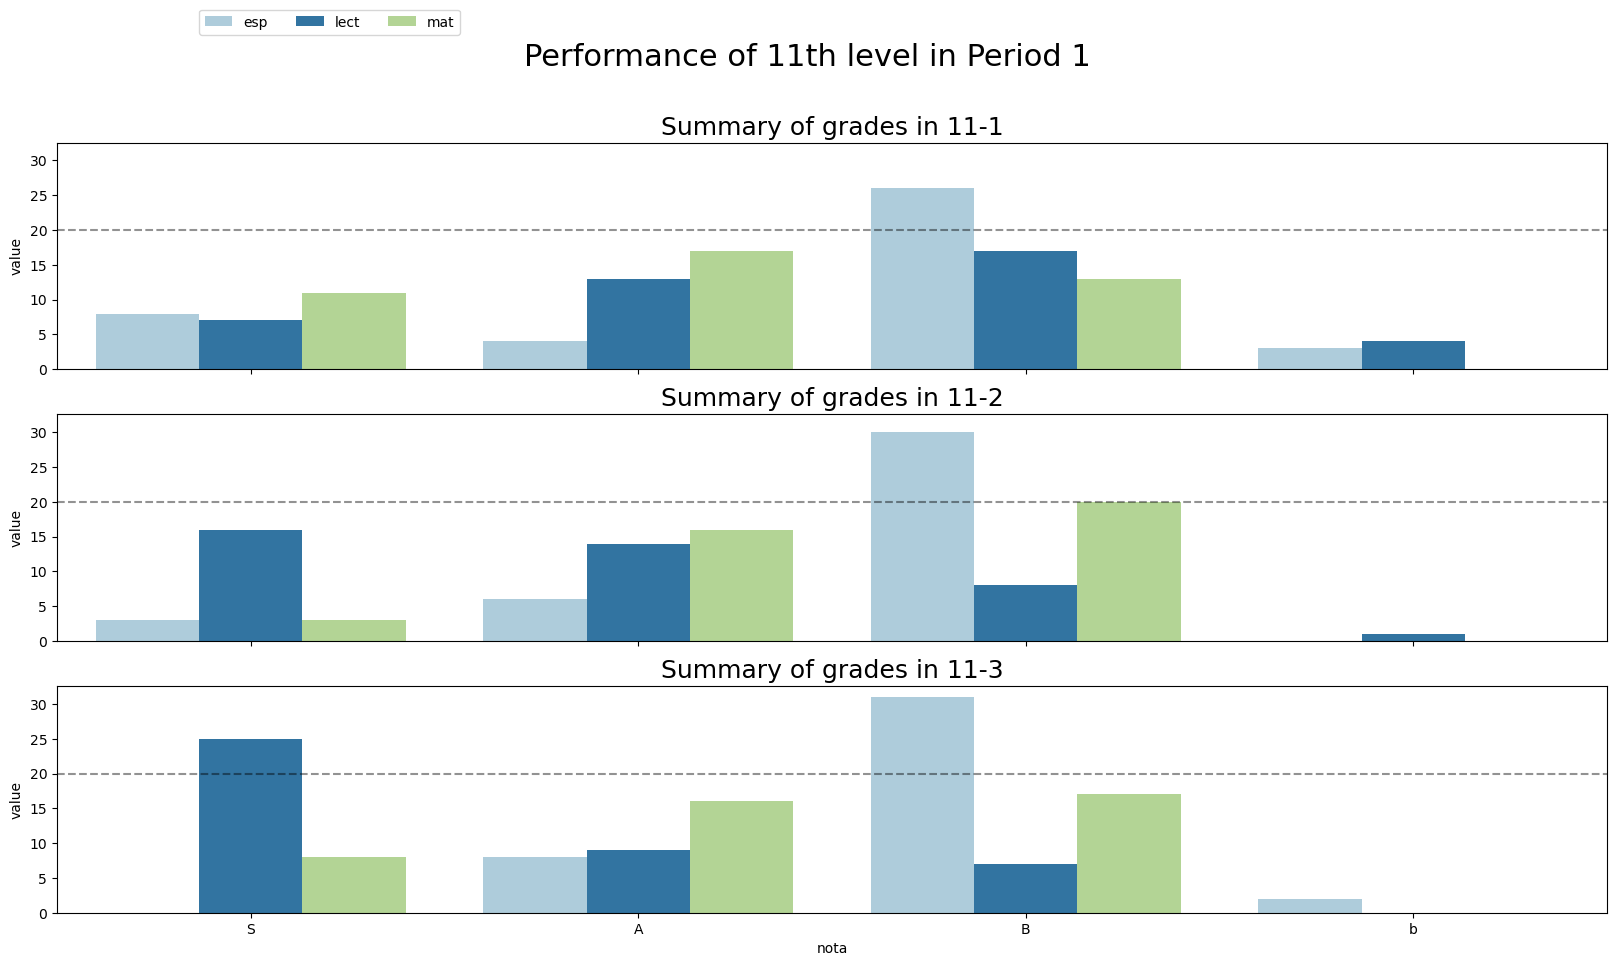

In [32]:
fig, axes = plt.subplots(3, 1, figsize=(20, 10), sharex=True, sharey=True)
titles = ["11-1", "11-2", "11-3"]
for ax, grades, title in zip(axes, [p1_11_1, p1_11_2, p1_11_3], titles):
    summary_subject_plot(grades, palette='Paired', ax=ax, show_legend=False, size=(14, 14), cols=cols_growns)
    ax.set_title(f"Summary of grades in {title}", fontdict={"fontsize": 18})
    ax.axhline(y=20, xmin=0, xmax=1, linestyle="--", linewidth=1.5, zorder=10, alpha=3/7, color='black')

handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc="upper right", ncol=4, bbox_to_anchor=(0.33, 1.02))

fig.tight_layout(rect=[0, 1, 1, 0.92])
plt.suptitle("Performance of 11th level in Period 1", fontsize=22)
plt.show()

#### 1.4.2 Period 2

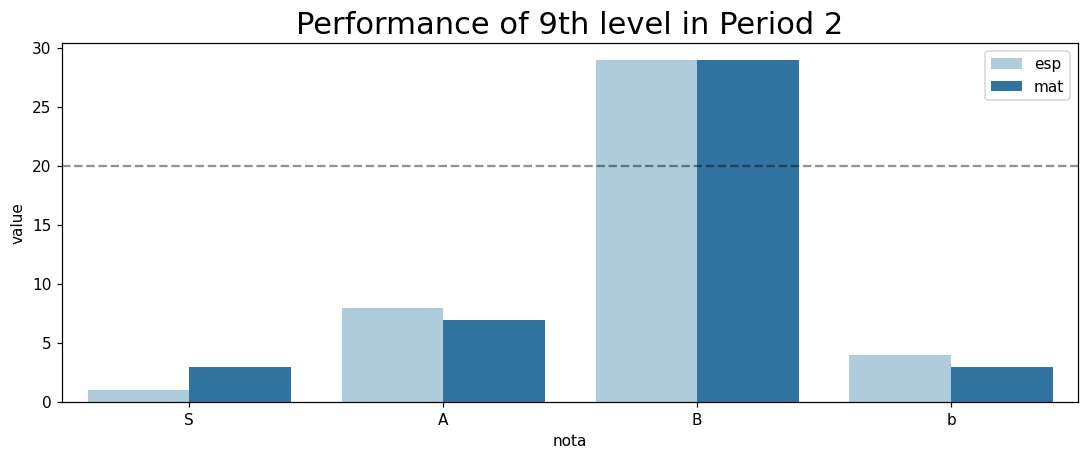

In [33]:
summary_subject_plot(p2_9_2, size=(10, 4), cols=cols_9, palette='Paired')
plt.axhline(y=20, xmin=0, xmax=1, linestyle="--", linewidth=1.5, zorder=10, alpha=3/7, color='black')
plt.title("Performance of 9th level in Period 2", fontsize=20)
plt.show()

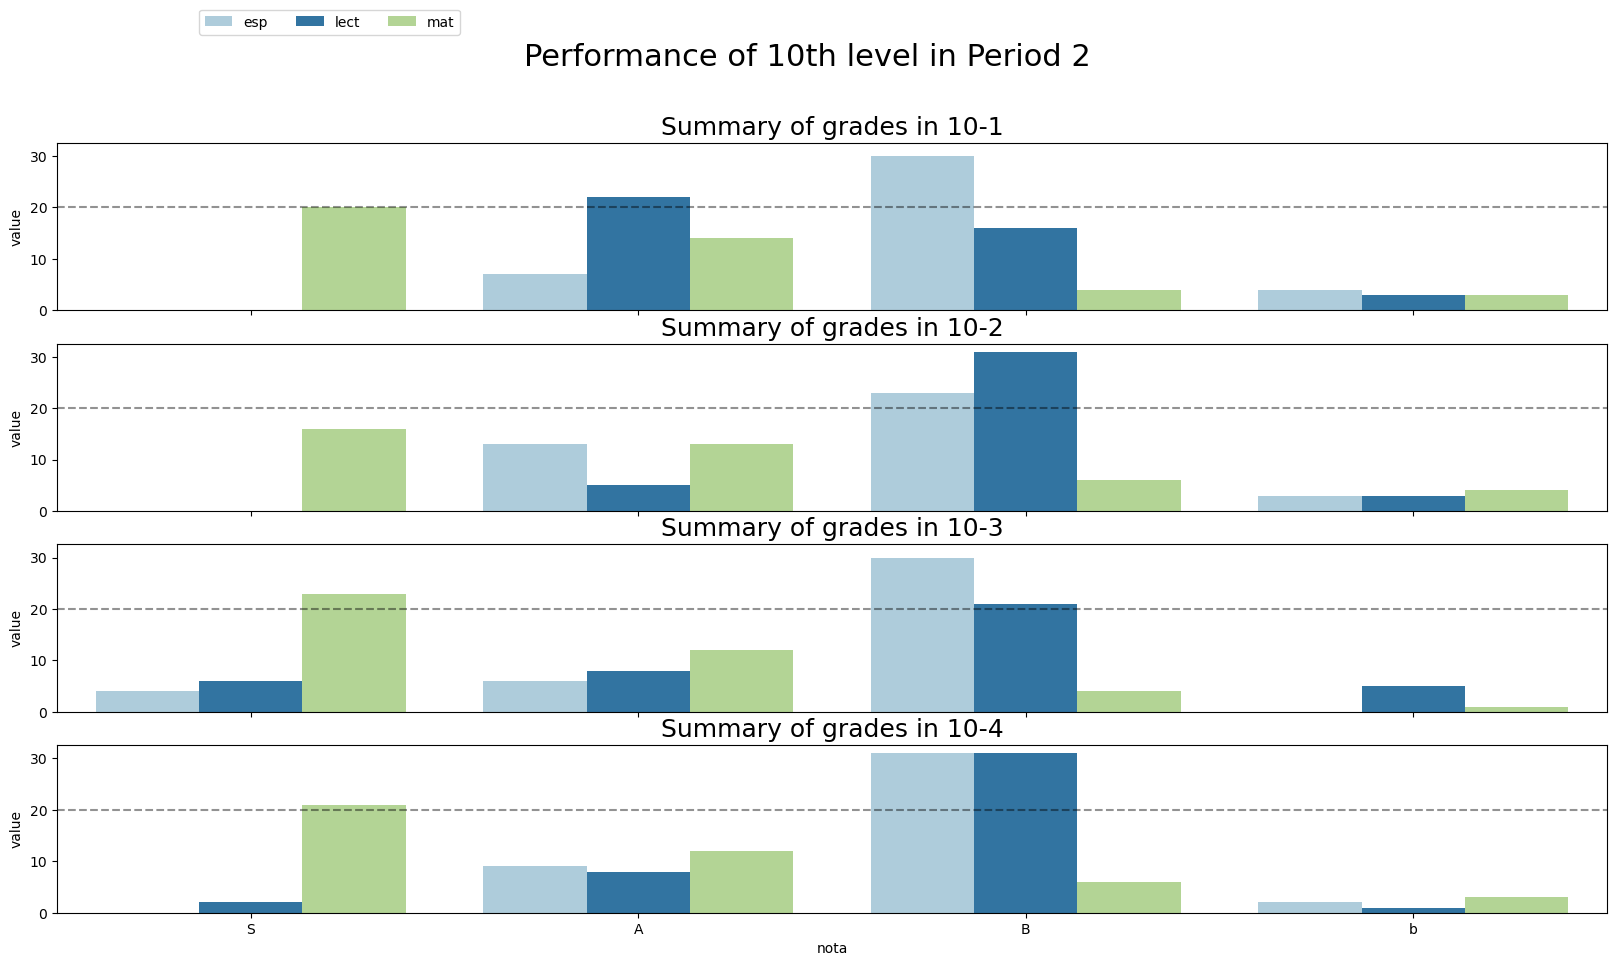

In [34]:
fig, axes = plt.subplots(4, 1, figsize=(20, 10), sharex=True, sharey=True)
titles = ["10-1", "10-2", "10-3", "10-4"]
for ax, grades, title in zip(axes, [p2_10_1, p2_10_2, p2_10_3, p2_10_4], titles):
    summary_subject_plot(grades, palette='Paired', ax=ax, show_legend=False, size=(14, 14), cols=cols_growns)
    ax.set_title(f"Summary of grades in {title}", fontdict={"fontsize": 18})
    ax.axhline(y=20, xmin=0, xmax=1, linestyle="--", linewidth=1.5, zorder=10, alpha=3/7, color='black')

handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc="upper right", ncol=4, bbox_to_anchor=(0.33, 1.02))

fig.tight_layout(rect=[0, 1, 1, 0.92])
plt.suptitle("Performance of 10th level in Period 2", fontsize=22)
plt.show()

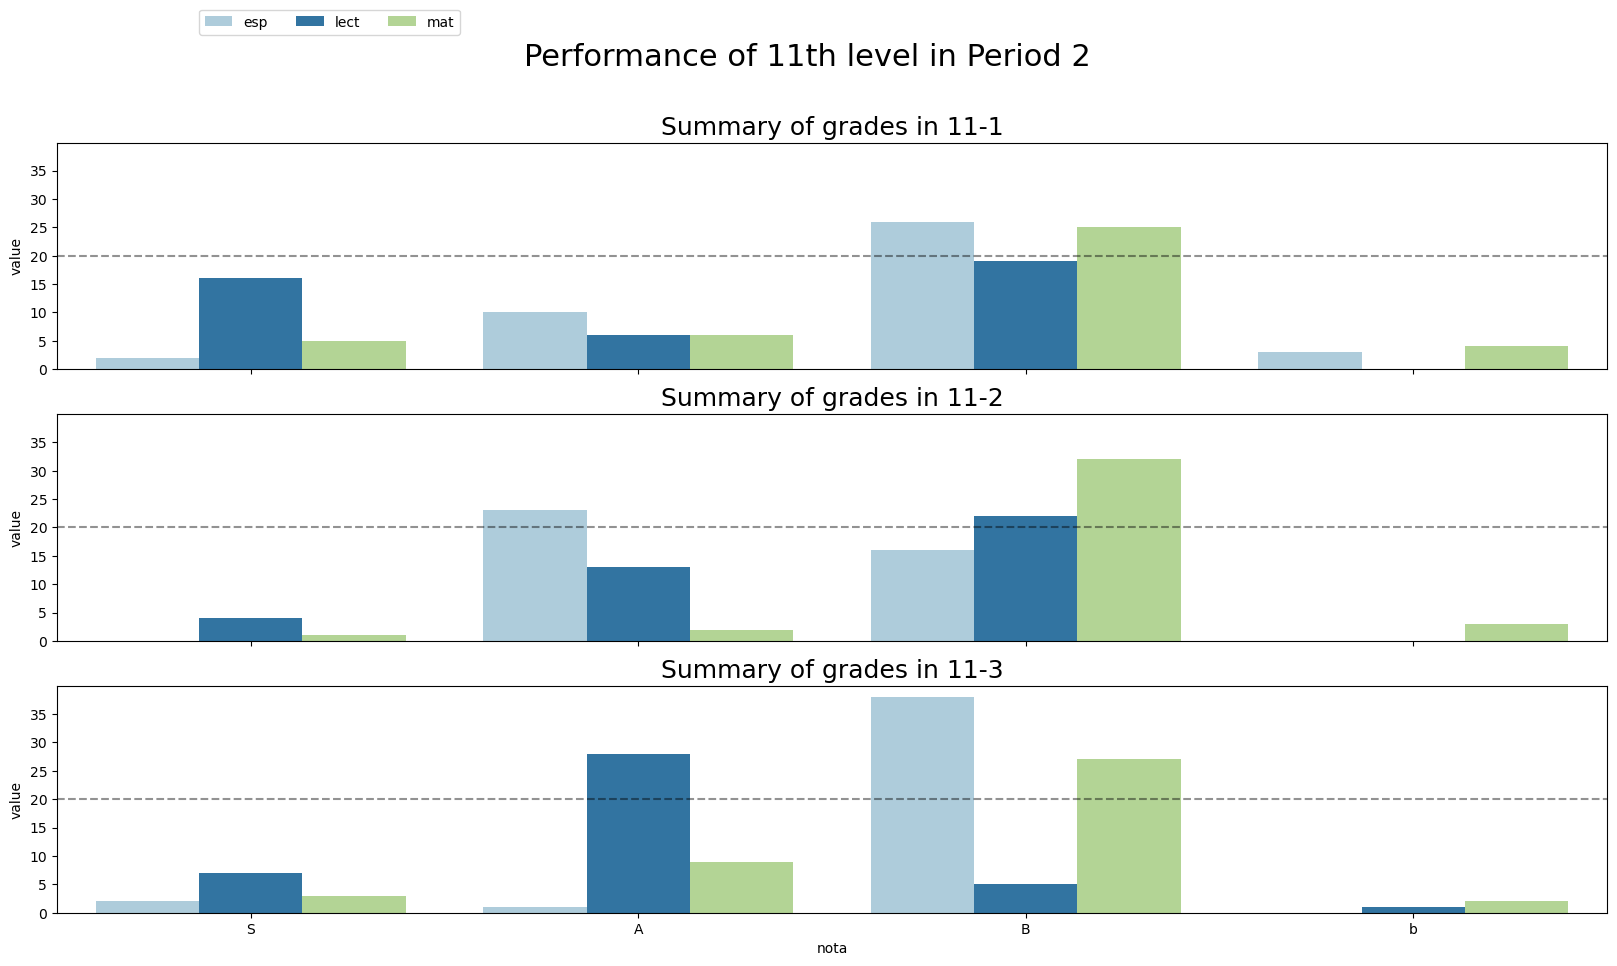

In [35]:
fig, axes = plt.subplots(3, 1, figsize=(20, 10), sharex=True, sharey=True)
titles = ["11-1", "11-2", "11-3"]
for ax, grades, title in zip(axes, [p2_11_1, p2_11_2, p2_11_3], titles):
    summary_subject_plot(grades, palette='Paired', ax=ax, show_legend=False, size=(14, 14), cols=cols_growns)
    ax.set_title(f"Summary of grades in {title}", fontdict={"fontsize": 18})
    ax.axhline(y=20, xmin=0, xmax=1, linestyle="--", linewidth=1.5, zorder=10, alpha=3/7, color='black')

handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc="upper right", ncol=4, bbox_to_anchor=(0.33, 1.02))

fig.tight_layout(rect=[0, 1, 1, 0.92])
plt.suptitle("Performance of 11th level in Period 2", fontsize=22)
plt.show()

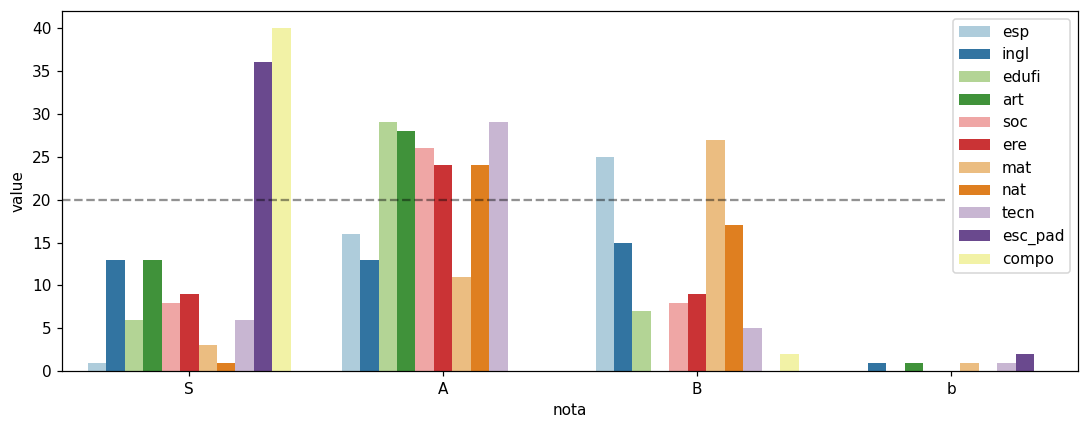

In [36]:
ax = summary_subject_plot(p1_9_2, palette='Paired', size=(10,4))
ax.axhline(y=20, xmin=0, xmax=0.87, linestyle="--", linewidth=1.5, zorder=10, alpha=3/7, color='black')
plt.show()

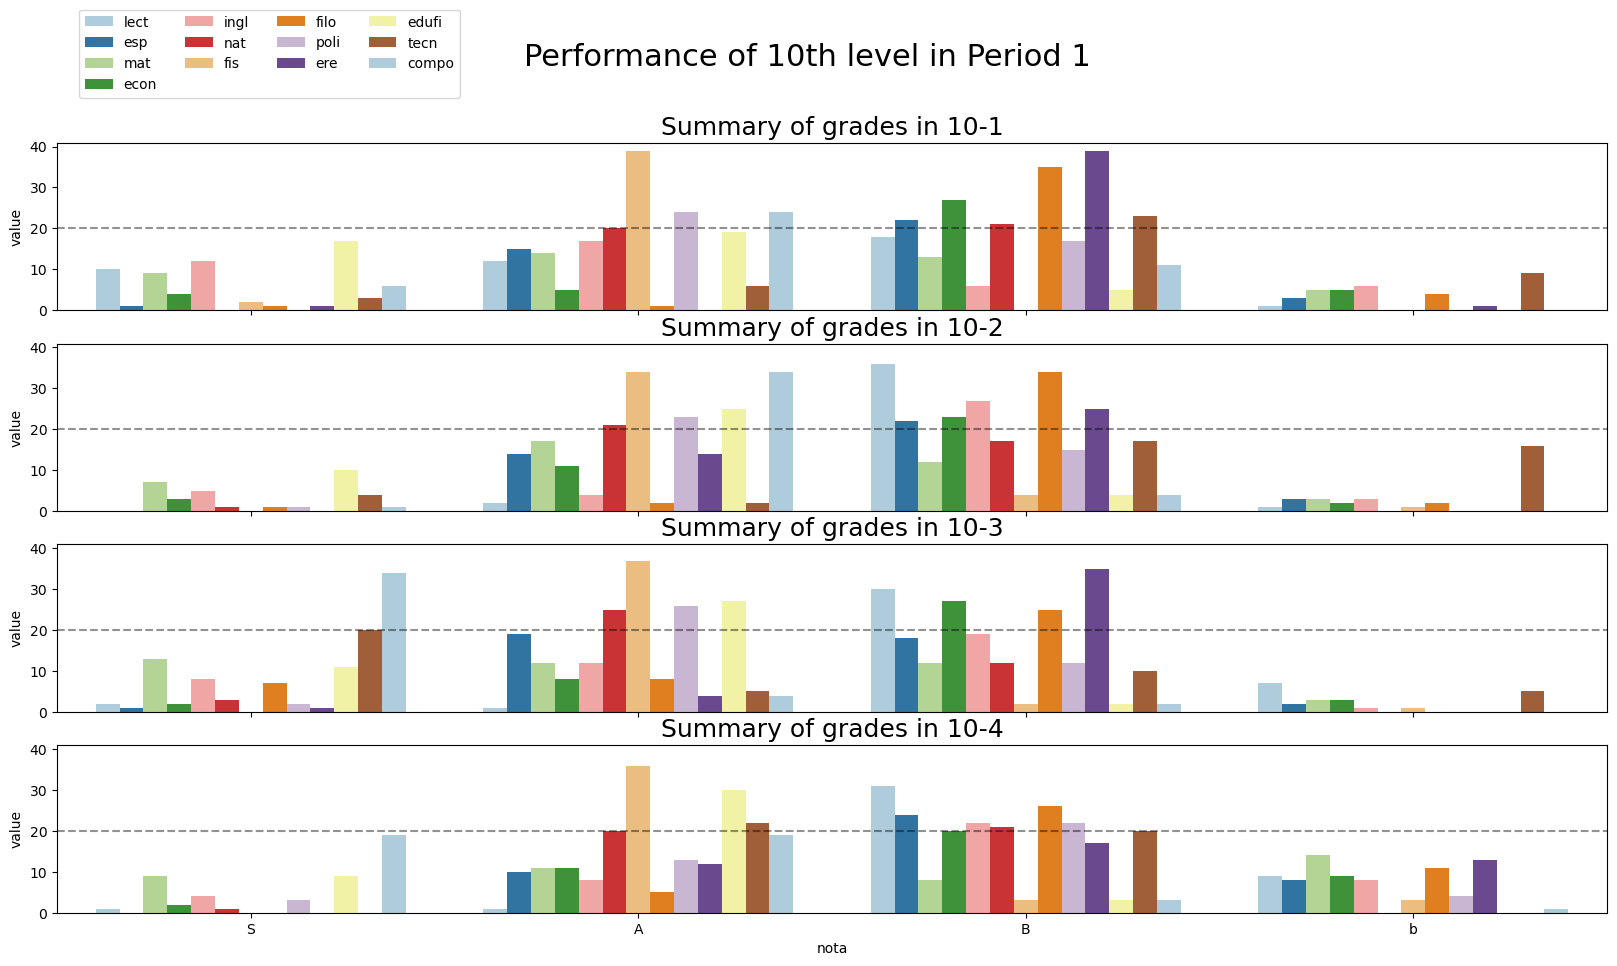

In [37]:
fig, axes = plt.subplots(4, 1, figsize=(20, 10), sharex=True, sharey=True)
titles = ["10-1", "10-2", "10-3", "10-4"]
for ax, grades, title in zip(axes, [p1_10_1, p1_10_2, p1_10_3, p1_10_4], titles):
    summary_subject_plot(grades, palette='Paired', ax=ax, show_legend=False, size=(14, 14))
    ax.set_title(f"Summary of grades in {title}", fontdict={"fontsize": 18})
    ax.axhline(y=20, xmin=0, xmax=1, linestyle="--", linewidth=1.5, zorder=10, alpha=3/7, color='black')

handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc="upper right", ncol=4, bbox_to_anchor=(0.33, 1.02))

fig.tight_layout(rect=[0, 1, 1, 0.92])
plt.suptitle("Performance of 10th level in Period 1", fontsize=22)
plt.show()


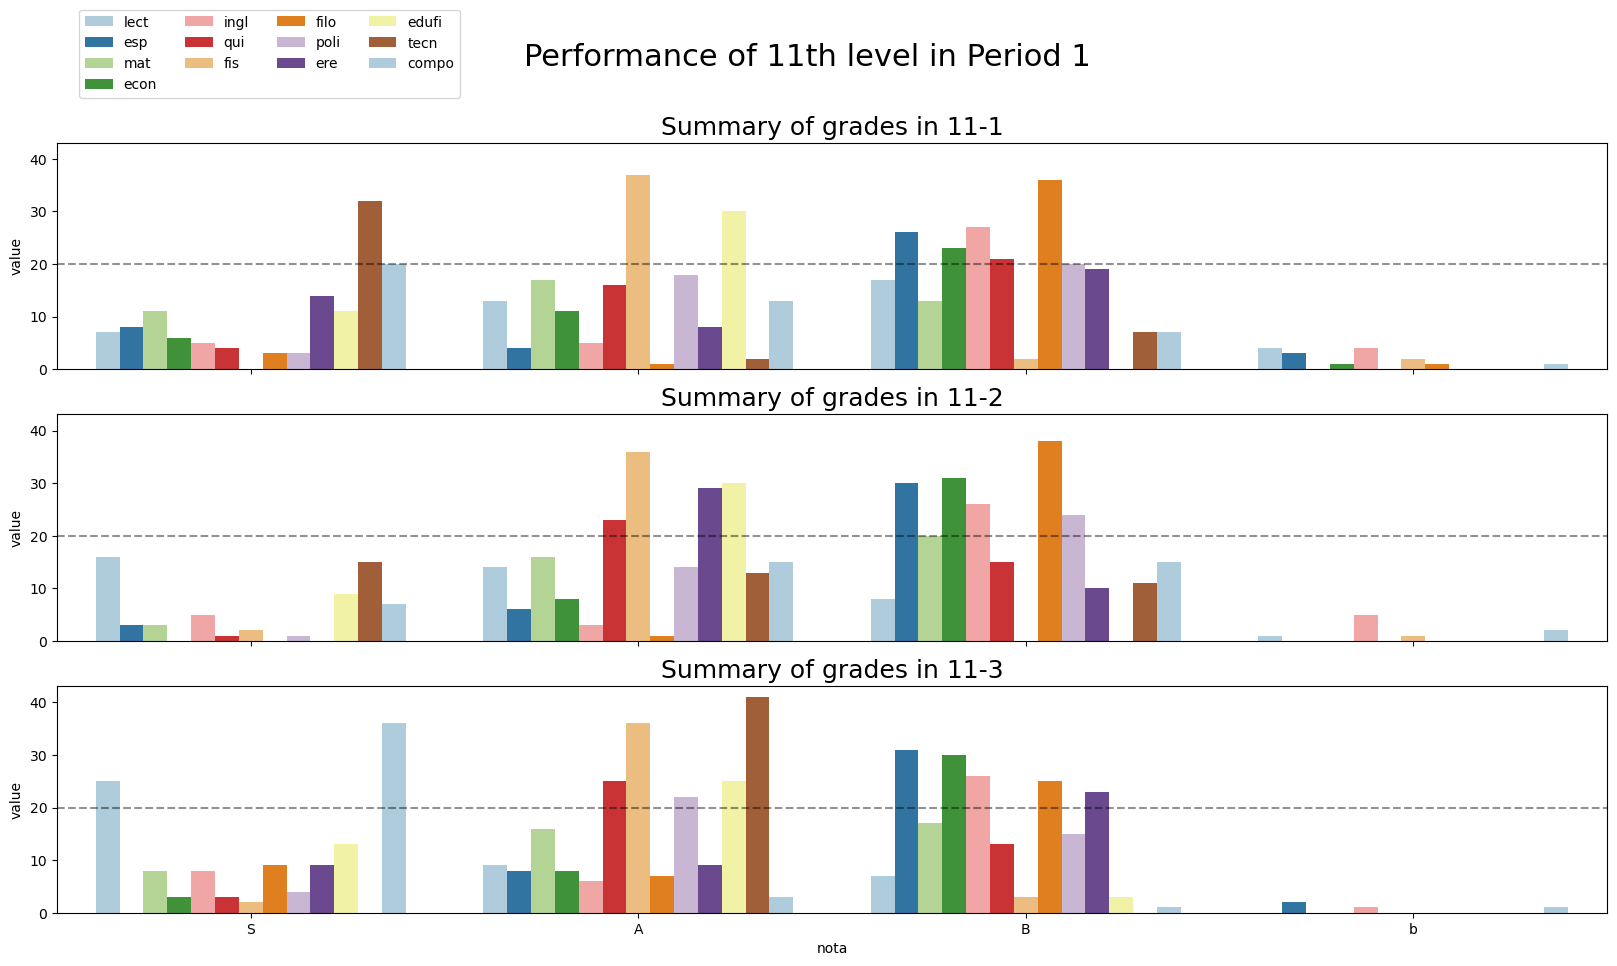

In [38]:
fig, axes = plt.subplots(3, 1, figsize=(20, 10), sharex=True, sharey=True)
titles = ["11-1", "11-2", "11-3"]
for ax, grades, title in zip(axes, [p1_11_1, p1_11_2, p1_11_3], titles):
    summary_subject_plot(grades, palette='Paired', ax=ax, show_legend=False, size=(14, 14))
    ax.set_title(f"Summary of grades in {title}", fontdict={"fontsize": 18})
    ax.axhline(y=20, xmin=0, xmax=1, linestyle="--", linewidth=1.5, zorder=10, alpha=3/7, color='black')

handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc="upper right", ncol=4, bbox_to_anchor=(0.33, 1.02))

fig.tight_layout(rect=[0, 1, 1, 0.92])
plt.suptitle("Performance of 11th level in Period 1", fontsize=22)
plt.show()


## 2. Training models

In [48]:
p1_10_1.columns[3:].tolist()

['lect',
 'esp',
 'mat',
 'econ',
 'ingl',
 'nat',
 'fis',
 'filo',
 'poli',
 'ere',
 'edufi',
 'tecn',
 'compo']

In [57]:
cols_to_classify = p1_10_1.columns[3:].tolist()

In [60]:
categories_per_col = order * len(cols_to_classify)

In [61]:
cat_ord_pipe = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy='most_frequent')),
        ("ordinal", OrdinalEncoder(
            categories=categories_per_col,
            handle_unknown='use_encoded_value',
            unknown_value=-1,
            dtype=np.float64
        ))
    ]
)

In [64]:
pre = ColumnTransformer(
    transformers=[
        ('cat', cat_ord_pipe, cols_to_classify)
    ],
    remainder='drop',
    verbose_feature_names_out=True
)

In [65]:
pre

ColumnTransformer(transformers=[('cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('ordinal',
                                                  OrdinalEncoder(categories=['S',
                                                                             'A',
                                                                             'B',
                                                                             'b',
                                                                             'S',
                                                                             'A',
                                                                             'B',
                                                                             'b',
                                                                             'S',
                                                                             'A',
                                                                             'B',
                                                                             'b',
                                                                             'S',
                                                                             'A',
                                                                             'B',
                                                                             'b',
                                                                             'S',
                                                                             'A',
                                                                             'B',
                                                                             'b',
                                                                             'S',
                                                                             'A',
                                                                             'B',
                                                                             'b',
                                                                             'S',
                                                                             'A',
                                                                             'B',
                                                                             'b',
                                                                             'S',
                                                                             'A', ...],
                                                                 handle_unknown='use_encoded_value',
                                                                 unknown_value=-1))]),
                                 ['lect', 'esp', 'mat', 'econ', 'ingl', 'nat',
                                  'fis', 'filo', 'poli', 'ere', 'edufi', 'tecn',
                                  'compo'])])

In [66]:
pre.fit_transform(p1_10_1)

ValueError: Shape mismatch: if categories is an array, it has to be of shape (n_features,).